In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import math

rootpath='./'
train_path = './train1'
test_path = './test1'

In [2]:
data = pd.read_csv("f_cal.csv")

In [3]:
data

,id,x,y,img1,img2
0,IMG4287_3,29.819322,-73.41728,IMG3442_3,IMG3375_4
1,IMG4288_5,91.219322,-38.91728,IMG2755_2,IMG3230_2
2,IMG4289_5,78.419322,-41.81728,IMG3018_5,IMG3510_5
3,IMG4290_4,-102.780678,116.88272,IMG3168_3,IMG3232_1
4,IMG4291_5,-87.080678,128.48272,IMG3207_1,IMG3279_5
...,...,...,...,...,...
1195,IMG5164_1,84.119322,-24.71728,IMG2804_3,NaN
1196,IMG5310_2,84.119322,-24.71728,IMG2804_3,NaN
1197,IMG5344_5,-0.680678,-68.61728,IMG2807_1,NaN
1198,IMG5348_4,2.619322,-67.01728,IMG2802_5,NaN


In [4]:
sift = cv2.SIFT_create()

In [5]:
def cal_f(test_img,train_img):
    # Compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(test_img,None)
    kp2, des2 = sift.detectAndCompute(train_img,None)
    
        # Draws the small circles on the locations of keypoints without size
#     kp1_without_size = cv2.drawKeypoints(test_img,kp1,None
#                                          #, color = (0, 0, 255) #If you want a specific colour
#                                         )
#     kp2_without_size = cv2.drawKeypoints(train_img,kp2,None
#                                          #, color = (0, 0, 255) #If you want a specific colour
#                                         )
    

#     # Draws a circle with the size of each keypoint and show its orientation
#     kp1_with_size = cv2.drawKeypoints(test,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#     kp2_with_size = cv2.drawKeypoints(train,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#     # Display images with&without the size of keypoints 
#     plt.subplots(figsize=(15, 10)) 

#     plt.subplot(2,2,1)
#     plt.imshow(kp1_without_size)  
#     plt.title('Original Image keypoints without size')
#     plt.axis('off')

#     plt.subplot(2,2,2)
#     plt.imshow(kp2_without_size, cmap='gray')  
#     plt.title('Scene Image keypoints without size')
#     plt.axis('off')
    
#     plt.show()
    
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    # Matching descriptor using KNN algorithm
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    ptsL = []
    ptsR = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8 *n.distance: # was 0.7
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt)

#     good = []
#     matchesMask = []
#     for m,n in matches:
#         if m.distance < 0.7*n.distance:
#             good.append(m)
#             matchesMask.append([1,0]) # Match
#         else:
#             matchesMask.append([0,0]) # Mismatch
            
#     # Draw all good matches
#     draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
#                        #singlePointColor = (255,0,0), #If you want a specific colour
#                         matchesMask = matchesMask,
#                         flags = cv2.DrawMatchesFlags_DEFAULT)

#     good_matches = cv2.drawMatchesKnn(test,kp1,train,kp2,matches,None,**draw_params)


#     plt.figure(figsize=(15, 15))

#     plt.imshow(good_matches, cmap='gray')
#     plt.title('All good matches')
#     plt.axis('off')

#     plt.show()

    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    
    F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_LMEDS)

    # Select only inlier points
    ptsL = ptsL[mask.ravel()==1]
    ptsR = ptsR[mask.ravel()==1]

    # print the fundamental matrix
    return F, mask, ptsL, ptsR, matches, kp1, kp2,

In [6]:
train = cv2.imread(os.path.join(train_path,"IMG3367_3.jpg"))
test = cv2.imread(os.path.join(test_path,"IMG4309_1.jpg"))
F, mask , ptsL, ptsR, matches, kp1, kp2= cal_f(test,train)
F

array([[-2.09157872e-07,  2.25996608e-05, -6.45342967e-03],
       [-2.11877975e-05, -9.41492678e-07,  3.62047722e-03],
       [ 4.76034939e-03, -6.10664450e-03,  1.00000000e+00]])

In [7]:
# mask

In [8]:
K = np.array([[(680/2)*math.tan(73.7/2),0,680/2],[0,490/(2*math.atan(24/2)),490/2],[0,0,1]])

In [9]:
K = np.array([[226.666667, 0, 340], [0, 226.666667, 245], [0, 0, 1]])

In [10]:
math.tan(73.7/2)

-1.1362957402334977

In [11]:
K

array([[226.666667,   0.      , 340.      ],
       [  0.      , 226.666667, 245.      ],
       [  0.      ,   0.      ,   1.      ]])

In [12]:
E = K.T.dot(F).dot(K)
E

array([[-0.01074607,  1.16112035, -0.223862  ],
       [-1.08858195, -0.0483718 , -0.86451565],
       [-0.11373559,  0.30522354, -0.14784181]])

In [13]:
def in_front_of_both_cameras(first_points, second_points, rot, trans):
    # check if the point correspondences are in front of both images
    rot_inv = rot
    for first, second in zip(first_points, second_points):
        first_z = np.dot(rot[0, :] - second[0]*rot[2, :], trans) / np.dot(rot[0, :] - second[0]*rot[2, :], second)
        first_3d_point = np.array([first[0] * first_z, second[0] * first_z, first_z])
        second_3d_point = np.dot(rot.T, first_3d_point) - np.dot(rot.T, trans)

        if first_3d_point[2] < 0 or second_3d_point[2] < 0:
            return False

    return True# K.T * cal_f(test,train) * K

In [14]:
# https://gist.github.com/jensenb/8668000

K_inv = np.linalg.inv(K)
first_match_points = np.zeros((len(matches), 2), dtype=np.float32)
second_match_points = np.zeros_like(first_match_points)
for i in range(len(matches)):
    first_match_points[i] = kp1[matches[i].queryIdx].pt
    second_match_points[i] = kp2[matches[i].trainIdx].pt

# decompose essential matrix into R, t (See Hartley and Zisserman 9.13)
U, S, Vt = np.linalg.svd(E)
W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,1.0]).reshape(3, 3)
# iterate over all point correspondences used in the estimation of the
# fundamental matrix
first_inliers = []
second_inliers = []
for i in range(len(mask)):
    if mask[i]:
        # normalize and homogenize the image coordinates
        first_inliers.append(K_inv.dot([ptsL[i][0],
                                ptsL[i][1], 1.0]))
        second_inliers.append(K_inv.dot([ptsR[i][0],
                                ptsR[i][1], 1.0]))
# Determine the correct choice of second camera matrix
# only in one of the four configurations will all the points be in
# front of both cameras
# First choice: R = U * Wt * Vt, T = +u_3 (See Hartley Zisserman 9.19)
for i in range(len(mask)):
    if mask[i]:
        # normalize and homogenize the image coordinates
        first_inliers.append(K_inv.dot([first_match_points[i][0], first_match_points[i][1], 1.0]))
        second_inliers.append(K_inv.dot([second_match_points[i][0], second_match_points[i][1], 1.0]))

# Determine the correct choice of second camera matrix
# only in one of the four configurations will all the points be in front of both cameras
# First choice: R = U * Wt * Vt, T = +u_3 (See Hartley Zisserman 9.19)
R = U.dot(W).dot(Vt)
T = U[:, 2]
if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):

    # Second choice: R = U * W * Vt, T = -u_3
    T = - U[:, 2]
    if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):

        # Third choice: R = U * Wt * Vt, T = u_3
        R = U.dot(W.T).dot(Vt)
        T = U[:, 2]

        if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):

            # Fourth choice: R = U * Wt * Vt, T = -u_3
            T = - U[:, 2]


In [15]:
R

array([[ 0.91690974,  0.02566451,  0.39826858],
       [ 0.07851878,  0.96682525, -0.24307147],
       [-0.39129443,  0.25414616,  0.88447634]])

In [16]:
T

array([-0.25682466, -0.09792112,  0.96148455])

In [17]:
p = np.array([29.81932192, -73.41728035, 1])


In [18]:
result = R.dot(p)+T
result

array([ 25.59885219, -68.9812962 , -28.48089349])

In [19]:
data = pd.read_csv("train.csv")
data

,id,x,y
0,IMG2744_1,-9.380678,3.58272
1,IMG2744_2,-9.380678,3.58272
2,IMG2744_3,-9.380678,3.58272
3,IMG2744_4,-9.380678,3.58272
4,IMG2744_5,-9.380678,3.58272
...,...,...,...
7495,IMG4243_1,-4.680678,35.18272
7496,IMG4243_2,-4.680678,35.18272
7497,IMG4243_3,-4.680678,35.18272
7498,IMG4243_4,-4.680678,35.18272


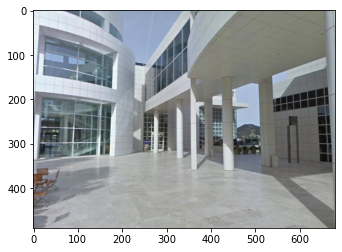

IMG2931_1


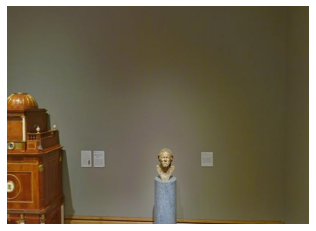

IMG2931_2


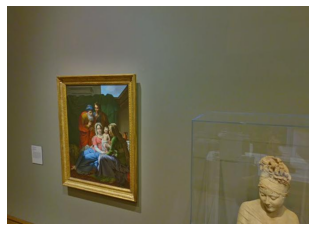

IMG2931_3


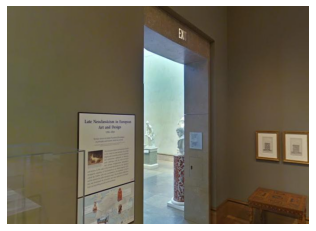

IMG2931_4


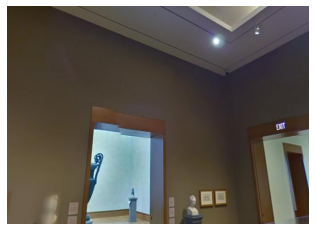

IMG2931_5


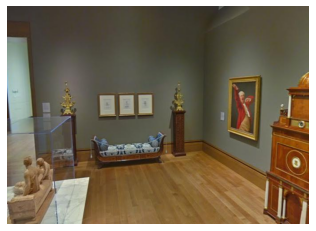

IMG3473_1


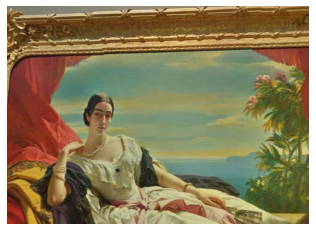

IMG3473_2


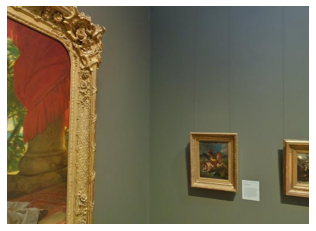

IMG3473_3


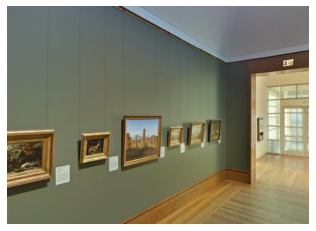

IMG3473_4


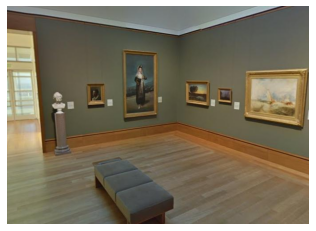

IMG3473_5


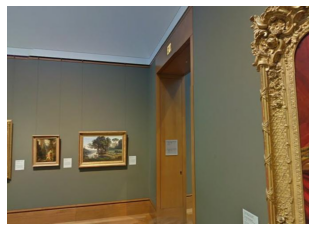

IMG4169_1


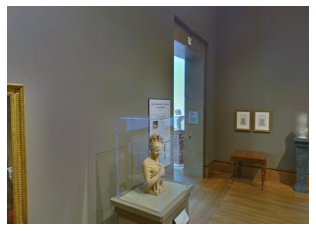

IMG4169_2


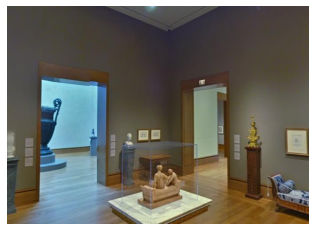

IMG4169_3


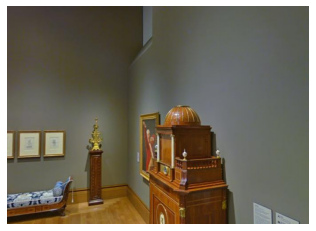

IMG4169_4


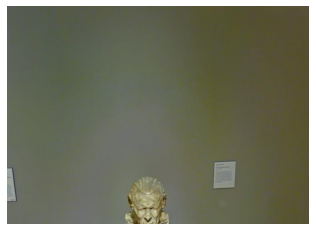

IMG4169_5


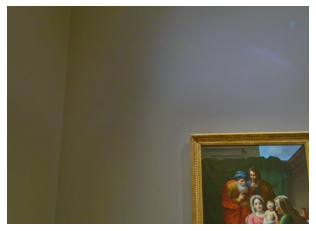

IMG4236_1


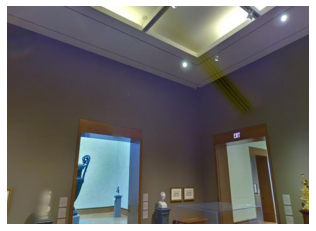

IMG4236_2


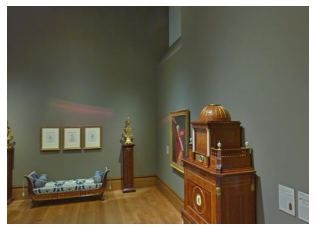

IMG4236_3


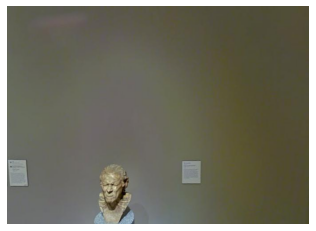

IMG4236_4


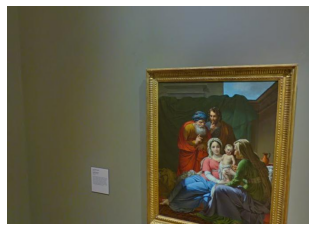

IMG4236_5


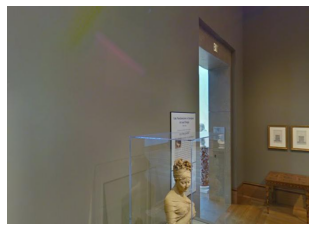

20

In [20]:
img = []
test = cv2.cvtColor(test,cv2.COLOR_BGR2RGB)
plt.imshow(test) 
plt.show()
for i in range(len(data.x)):
    if abs(data.x[i] - result[0] )<2 and abs(data.y[i] - result[1]) < 2:
        img.append(data.id[i])
        train = cv2.imread(os.path.join(train_path,data.id[i]+".jpg"))
        train = cv2.cvtColor(train,cv2.COLOR_BGR2RGB)
        print(data.id[i])
        plt.imshow(train)  
        plt.axis('off')
        plt.show()
len(img)